In [1]:
import numpy as np
import pandas as pd
import nltk
import scipy as sp
import sklearn as sk
import os,time,re,string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics

* 大概思路：利用正负面描述的 **词语频率** 预测Amazon的商品评价
    1. 读取文字描述，查看大概数据情况
    2. 整理标签(>3 stars = positive)
    3. 整理summary文字，并建立语料库
    4. 建模
    5. 结果

In [2]:
review_raw = pd.read_csv('./data/Reviews.csv')

In [3]:
review_raw.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
review_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
review_raw.isnull().sum(axis=0)

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [6]:
review_raw.Score.unique().shape[0]

5

In [7]:
n_samples = review_raw.shape[0]
n_samples

568454

In [8]:
df_uni = pd.DataFrame(index=range(10),
                      columns=['Feature','No. of NAs','No. of Unique Values','# of total samples','Unique_Percentage(%)'])


In [9]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [10]:
for i,feat in enumerate(review_raw.columns.values):
    feat_na = review_raw[feat].isnull().sum(axis=0)
    feat_uni = review_raw[feat].unique().shape[0]
    perc = feat_uni/n_samples * 100
    df_uni.iloc[i,:] = [feat, feat_na,feat_uni, n_samples, perc]

In [11]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,Id,0,568454,568454,100
1,ProductId,0,74258,568454,13.0632
2,UserId,0,256059,568454,45.0448
3,ProfileName,16,218417,568454,38.423
4,HelpfulnessNumerator,0,231,568454,0.0406365
5,HelpfulnessDenominator,0,234,568454,0.0411643
6,Score,0,5,568454,0.000879579
7,Time,0,3168,568454,0.557301
8,Summary,26,295744,568454,52.026
9,Text,0,393579,568454,69.2367


In [12]:
review = review_raw.dropna()

In [13]:
review.shape

(568412, 10)

### 2. 整理label, 作为正负评价的标签
* 将结果分为两类: positive (score > 3) and negative (score <= 3)

In [14]:
label = review['Score'].apply(lambda x: 1 if x>3 else 0 )

In [23]:
label.head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

### 3 整理summary文字栏

* 去标点等符号
* 分词
* stopwords,去掉stopwords
* 词干提取Stemming与词形还原Lemmatization
* 清洗结果对比

In [16]:
summary = review['Summary']
summary.head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

#### 3.1 数据清洗: 去掉标点符号
* 不要忘记import string
* import string
* string.punctuation

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
trantable = str.maketrans('','',string.punctuation)
def data_clean(text):
    text = text.lower()
    text_clean = text.translate(trantable)
    return text_clean

In [19]:
# test
l1 = 'hi, whats up*^@^*&!@#...'
data_clean(l1)

'hi whats up'

# Issue 1 -  str.maketrans('','',string.punctuation)
```python
import string
# This uses the 3-argument version of str.maketrans with arguments (x, y, z) where 'x' and 'y'
# must be equal-length strings and characters in 'x' are replaced by characters in 'y'. 
# 'z' is a string(string.punctuation here) where each character in the string is mapped to None
translator = str.maketrans('', '', string.punctuation)
s = 'string with "punctuation" inside of it! Does this work? I hope so.'
print(s.translate(translator))
=> string with punctuation inside of it Does this work I hope so
```

# Explaination 

```python
str.maketrans('abc', 'xyz', 'hij')

# This is the same as the two argument version, except that the characters from the third string are removed, 
# as if they were mapped to None. 
# So your table is saying "Don't replace anything, but remove the characters that show up in this string".
```
<p style='color:red'>Don't replace anything, but remove the characters that show up in this string</p>
**Don't replace anything, but remove the characters that show up in this string**

reference: [How to explain the str.maketrans function in Python 3.6?](https://stackoverflow.com/questions/41535571/how-to-explain-the-str-maketrans-function-in-python-3-6#41536036)

In [20]:
summary = summary.apply(lambda x: data_clean(x))

In [22]:
summary.head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

#### 3.2 分词 tokenize

In [34]:
from nltk import word_tokenize
demo = summary[:5000]
corpus_w_stopword = [word_tokenize(text) for text in demo]

In [37]:
corpus_w_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['not', 'as', 'advertised'],
 ['delight', 'says', 'it', 'all'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'just', 'as', 'good', 'as', 'the', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

#### 3.2 去掉停用词 stopwords

corpus:全集，文集; 资金，本金; [计] 语料库; 器官

In [38]:
from nltk import FreqDist
from nltk.corpus import stopwords

In [39]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [40]:
def remove_stopword(text):
    return [word for word in text if word not in stopwords.words('english')]

In [41]:
corpus_wo_stopword = [remove_stopword(text) for text in corpus_w_stopword]

In [45]:
corpus_wo_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['advertised'],
 ['delight', 'says'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'good', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

- list.append()
- list.extend()
- np.hstack() 效果同于list.extend()，打破原来的子列表，组合成只有word的整体list

In [43]:
corpus_wo_h = np.hstack(corpus_wo_stopword)

In [48]:
corpus_w_h = np.hstack(corpus_w_stopword)

In [54]:
print('Unduplicated words without stopwords: {}'.format(len(set(corpus_wo_h))))
print('Unduplicated words with stopwords: {}'.format(len(set(corpus_w_h))))

Unduplicated words without stopwords: 3187
Unduplicated words with stopwords: 3301


#### 3.4 词干提取和词性还原 - 时态，单复数

In [55]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [61]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [65]:
print('eating 词干是: {}'.format(porter.stem('eating')))
print('feet 词性还原是: {}'.format(wnl.lemmatize('feet')))

eating 词干是: eat
feet 词性还原是: foot


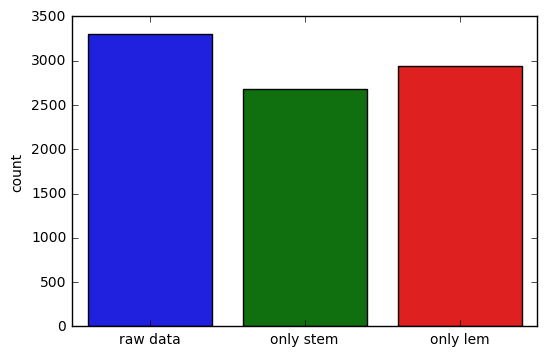

In [83]:
plt.figure()
sns.barplot(x = ['raw data','only stem','only lem'],
            y = [len(set(corpus_w_h)),len(set(stem_wo)),len(set(lem_wo))])
plt.ylabel('count')
plt.show()

In [76]:
stem_wo = [porter.stem(word) for word in corpus_wo_h]
lem_wo = [wnl.lemmatize(word) for word in corpus_wo_h]

- 去粗stopwords后的词频

In [102]:
FreqDist(corpus_wo_h)

FreqDist({'rican': 1,
          'crab': 2,
          'dripping': 1,
          'noticeable': 1,
          'grahams': 1,
          'deliciously': 2,
          'beef': 7,
          'soft': 9,
          'additive': 2,
          'tasking': 1,
          'thai': 9,
          'aint': 1,
          'herrs': 1,
          'current': 1,
          'twice': 4,
          'away': 6,
          'yummier': 1,
          'redbard': 1,
          'gaaak': 1,
          'cakes': 3,
          'flavorless': 1,
          'citizens': 1,
          'delisious': 1,
          'earl': 3,
          'purchaser': 1,
          'pepper': 2,
          'schmaffles': 1,
          'sour': 3,
          'thailand': 1,
          'tortilla': 9,
          'harmony': 2,
          'figure': 1,
          'fowl': 1,
          'amazingly': 2,
          'sausage': 1,
          'dishes': 5,
          'sardine': 1,
          'vinci': 1,
          'gagging': 1,
          'onestar': 1,
          'omega3s': 1,
          'lowers': 1,
          '

In [92]:
list(FreqDist(corpus_wo_h).items())

[('rican', 1),
 ('crab', 2),
 ('dripping', 1),
 ('noticeable', 1),
 ('grahams', 1),
 ('deliciously', 2),
 ('beef', 7),
 ('antibiotics', 1),
 ('additive', 2),
 ('tasking', 1),
 ('thai', 9),
 ('aint', 1),
 ('herrs', 1),
 ('current', 1),
 ('away', 6),
 ('looks', 5),
 ('redbard', 1),
 ('gaaak', 1),
 ('cakes', 3),
 ('flavorless', 1),
 ('citizens', 1),
 ('delisious', 1),
 ('earl', 3),
 ('purchaser', 1),
 ('pepper', 2),
 ('schmaffles', 1),
 ('beast', 1),
 ('thailand', 1),
 ('tortilla', 9),
 ('harmony', 2),
 ('figure', 1),
 ('fowl', 1),
 ('yahoo', 1),
 ('dishes', 5),
 ('sardine', 1),
 ('vinci', 1),
 ('onestar', 1),
 ('omega3s', 1),
 ('lowers', 1),
 ('sorry', 2),
 ('naturally', 2),
 ('repeated', 1),
 ('pounds', 2),
 ('mackeral', 1),
 ('clams', 4),
 ('health', 8),
 ('two', 5),
 ('adzuki', 1),
 ('fry', 1),
 ('need', 10),
 ('barely', 2),
 ('canin', 1),
 ('assorted', 1),
 ('breed', 2),
 ('slight', 3),
 ('jja', 1),
 ('told', 1),
 ('move', 1),
 ('cultures', 1),
 ('really', 50),
 ('yet', 8),
 ('family

In [104]:
FreqDist(corpus_wo_h).most_common(10)

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [148]:
fdist_wo = pd.DataFrame(list(FreqDist(corpus_wo_h).items()), columns=['word wo','freq wo'])
fdist_wo.sort_values(by='freq wo',inplace=True,ascending=False)
fdist_wo.head()

,word wo,freq wo
1216,great,690
2103,good,479
164,best,341
2585,love,215
182,taste,179


In [149]:
fdist_w = pd.DataFrame(list(FreqDist(corpus_w_h).items()),columns=['word w','freq w'])
fdist_w.sort_values(by='freq w',ascending=False,inplace=True)
fdist_w.head()

,word w,freq w
1249,great,690
1386,the,482
2172,good,479
894,for,384
1471,best,341


-----
# Issue 2 -내 생각
제일 많이 나오는 단어로 차트를 만드는건데 FreqDist().most_common()를 이용하면 어떨까?


In [142]:
freq_wo =FreqDist(corpus_wo_h).most_common(10) 
freq_wo

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [147]:
dict(freq_wo).items()

dict_items([('product', 161), ('taste', 179), ('coffee', 141), ('tea', 140), ('delicious', 164), ('best', 341), ('great', 690), ('love', 215), ('chips', 162), ('good', 479)])

In [146]:
freq_wo_df = pd.DataFrame(list(dict(freq_wo).items()),columns=['a','b'])
freq_wo_df.sort_values(by='b',ascending=False,inplace=True)
freq_wo_df

,a,b
6,great,690
9,good,479
5,best,341
7,love,215
1,taste,179
4,delicious,164
8,chips,162
0,product,161
2,coffee,141
3,tea,140


<p style='color:red'>내 생각 끝. 강의 코드 보다 복잡하다</p>

-----

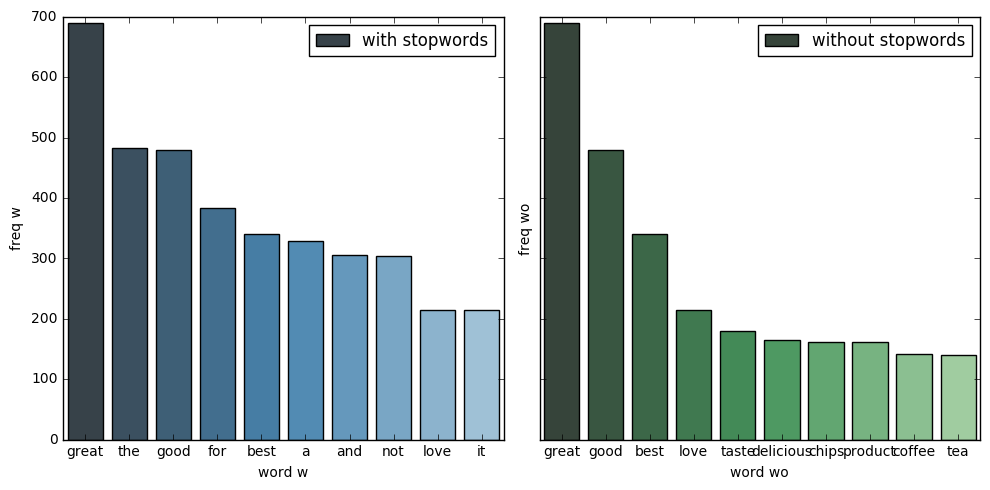

In [157]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.barplot(x=fdist_w['word w'][:10], 
            y=fdist_w['freq w'][:10],
            palette='Blues_d',ax=ax1,label='with stopwords')

sns.barplot(x=fdist_wo['word wo'][:10], 
            y=fdist_wo['freq wo'][:10],
            palette='Greens_d',ax=ax2,label='without stopwords')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
